# NeuroCLAV tutorial

In this short tutorial we will go over the basic usage of the `NeuroCLAV` library.

* If you haven't already, start by cloning the repository and adding the module to your path:

In [1]:
![ -d "NeuroCLAV" ] || git clone 'https://github.com/Duplums/NeuroCLAV'
import sys
sys.path.append('NeuroCLAV')

* Make sure you have all the requirements listed in `environment.yml` e.g. using Anaconda:

In [2]:
!conda env create -f environment.yml

/bin/bash: ligne 1: conda : commande introuvable


## Preparing the data

`NeuroCLAV` comes with the `UKB` class, a wrapper for the [UK Biobank](https://www.ukbiobank.ac.uk/) which subclasses PyTorch's `Dataset`.

* To create an instance, we need to specify the data directory as well as a CSV or `Dataframe` with whatever phenotypes (aka labels, aka metadata, aka auxiliary variables) we wish to pretrain the model with.

In [3]:
data_dir = '/neurospin/psy_sbox/all_studies/derivatives/arrays/ukb_cat12vbm_mwp1'
labels_file = '/neurospin/psy_sbox/bd261576/medical_datasets/ukb/filtered_coarse_phenotypes.csv'

This `labels_file` contains subject phenotypes indexed by patient number (column `participant_id`). For the purpose of this tutorial we'll only be using the `age-2` column.

In [4]:
import pandas as pd

labels = pd.read_csv(labels_file).rename(columns = {'age-2': 'age'})
print(labels[0:10][["participant_id", "age"]])

  participant_id        age
0    sub-1000021  51.953425
1    sub-1000325  52.052055
2    sub-1000458  68.600000
3    sub-1000575  64.408219
4    sub-1000606  58.621918
5    sub-1000715  70.980822
6    sub-1000963  71.063014
7    sub-1001107  63.172603
8    sub-1001393  70.221918
9    sub-1001428  60.630137


(In the [UKB encoding](https://biobank.ndph.ox.ac.uk/ukb/coding.cgi?id=9), 0 stands for female and 1 for male.

* Now we can instantiate the `UKB` class:

In [5]:
from data.datasets.ukb import UKB

dataset = UKB(
    data_dir,
    labels,
    phenotypes=["age"],
    modality='roi',
    )

The `phenotypes` keyword specifies which columns to load from `labels`, and `modality` (`"vbm"` or `"roi"`) specifies whether to load the [full MRIs](https://en.wikipedia.org/wiki/Voxel-based_morphometry) or just the regions of interest.

* The `Dataset` interface makes it easy to obtain a train/test split:

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import Subset

train_idx, test_idx = train_test_split(range(len(dataset)), train_size=10000, test_size=2000)

data_train = Subset(dataset, indices=train_idx)
data_test = Subset(dataset, indices=test_idx)

## Training a model

In [7]:
from manifold.neuroclav import NeuroCLAV

model = NeuroCLAV(
    encoder = 'mlp287x128x128x128x128x128', # MLP with 5 hidden layers (287 = # of MRIs)
    n_components = 2,                       # dimension of latent space
    max_iteration = 100                     # number of epochs for training
)

The `NeuroCLAV` class integrates with the Scikit-learn interface, so the following methods are implemented:

* `NeuroCLAV.fit` fits the model using from a labeled database,

* `NeuroCLAV.transform` encodes an unseen sample in the latent space,

* `NeuroCLAV.predict` predicts the label from an unseen sample.

Recall that in the [SimCLR framework](https://arxiv.org/abs/2002.05709), on which NeuroCLAV is based, input data is augmented in any number of ways (e.g. by rotating, cropping or adding noise) in order to train the model to become invariant to those transformations. In practice this means passing a custom collate function to the data loader via the `collate_fn` argument in `NeuroCLAV.fit`.

You should find a pretrained `model.pkl` file included, but feel free to delete it and train the model from scratch.

In [8]:
from os.path import isfile
import pickle

if not isfile('model.pkl'):
    from data.collate import TwoViewsCollateFunction
    
    two_views = TwoViewsCollateFunction() # base collate function that creates no augmentations
    model.fit(data_train, collate_fn=two_views)
    
    with open('model.pkl', 'wb') as file:
        pickle.dump(model, file)
else:
    with open('model.pkl', 'rb') as file:
        model = pickle.load(file)

## Visualising the latent space

Use the following block of code to visualize the test sample over the latent space:

[Text(0.5, 1.0, 'True phenotypes over latent space')]

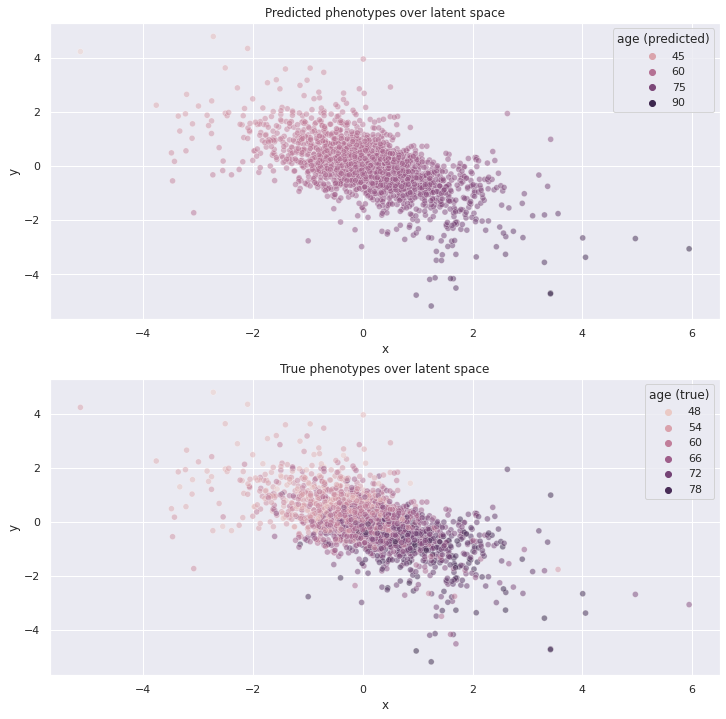

In [11]:
from sklearn.manifold import TSNE

points = model.transform(data_test, collate_fn="base")
points = pd.DataFrame(points, columns = ["x", "y"])

labels_pred, labels_true = model.predict(data_test, collate_fn="base", return_y=True)

points["age (predicted)"] = dataset.label_scaler.inverse_transform(labels_pred)
points["age (true)"] = dataset.label_scaler.inverse_transform(labels_true)

import seaborn as sns
import matplotlib.pyplot as plt

figure, axes = plt.subplots(nrows=2)

sns.scatterplot(
    data=points, x="x", y="y",
    hue="age (predicted)",
    alpha=.5,
    ax=axes[0]
    ).set(title="Predicted phenotypes over latent space")

sns.scatterplot(
    data=points, x="x", y="y",
    hue="age (true)",
    alpha=.5,
    ax=axes[1]
    ).set(title="True phenotypes over latent space")

[Text(0.5, 1.0, 'True vs. predicted age')]

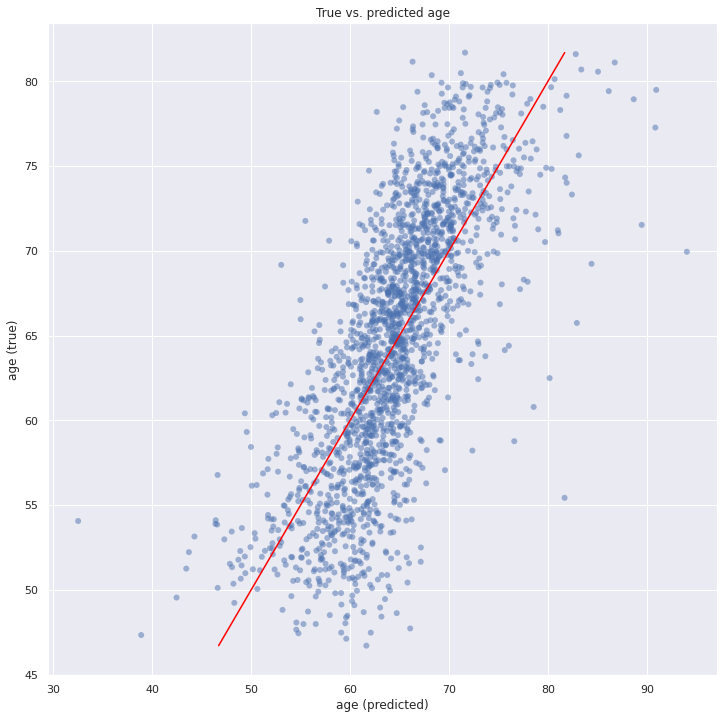

In [12]:
age_range = [min(points["age (true)"]), max(points["age (true)"])]

sns.lineplot(
    x=age_range, y=age_range,
    color="red",
    legend="auto",
)

sns.scatterplot(
        data=points, x="age (predicted)", y="age (true)",
        edgecolor="none", alpha=.5,
        legend=False,
        ).set(title="True vs. predicted age")